/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9,19,28,29,52,54,58,91,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


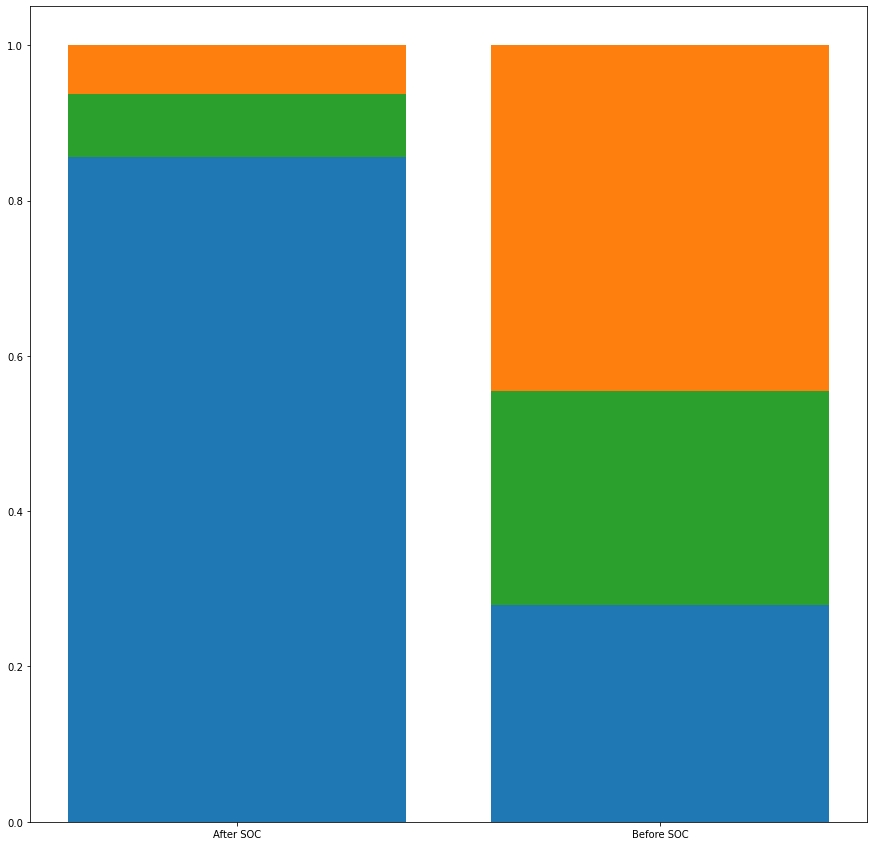

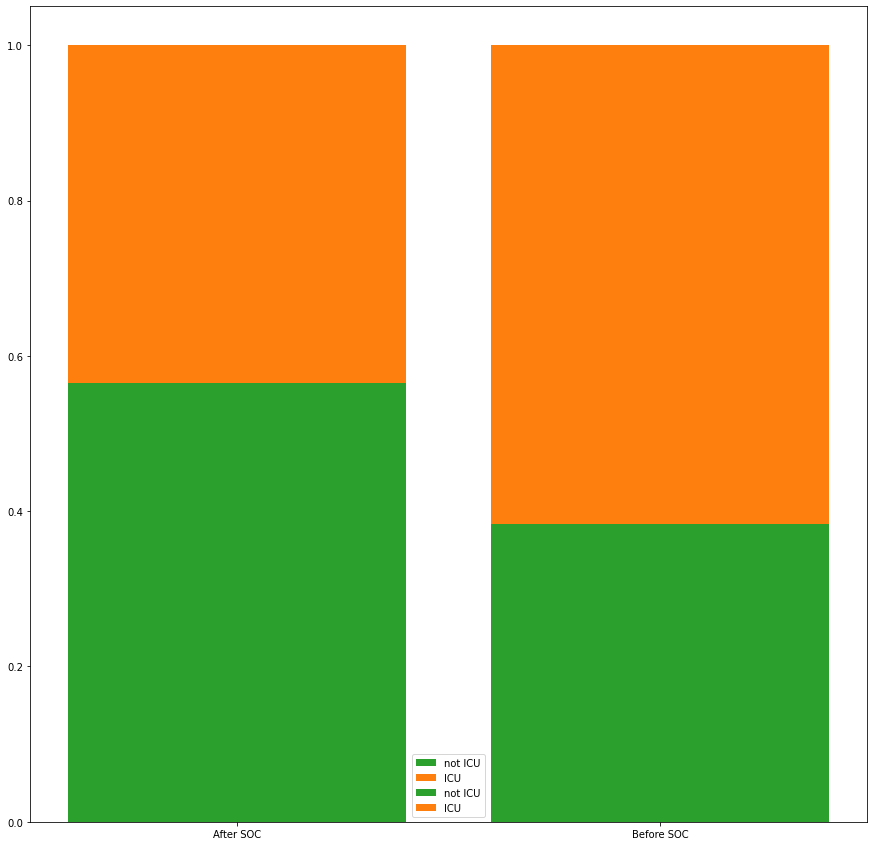

In [20]:
'''
Script to visualize deterioration index (DI) score and clinical outcomes before and after Aug 1st
Epidemiological data pulled from IDPH. 
'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from scipy.stats import mannwhitneyu, wilcoxon
import itertools
from sklearn.preprocessing import StandardScaler
from numpy import inf
import math
from statsmodels.stats.multitest import multipletests
from matplotlib.pyplot import cm
from sklearn.cluster import AgglomerativeClustering


df = pd.read_csv('/Users/tlh4362/Desktop/final_dataset_analysis_11_2.csv')
risk = pd.read_csv('/Users/tlh4362/Desktop/risk_scores.csv')
fig6 = pd.read_csv('/Users/tlh4362/Desktop/fig6.csv')


df['sample_date'] = pd.to_datetime(df['sample_date'])
aftersocall = df[(df['sample_date'] >= pd.to_datetime('2020-08-01')) & (df['sample_date'] <= pd.to_datetime('2021-02-01'))]

outpt = aftersocall['ca_hosp_admit'].value_counts().loc[0]/aftersocall.shape[0]
nonicu = aftersocall[aftersocall['ca_hosp_admit']==1]['ICU'].value_counts().loc[0]/aftersocall.shape[0]
icu = aftersocall[aftersocall['ca_hosp_admit']==1]['ICU'].value_counts().loc[1]/aftersocall.shape[0]

beforesocall = df[(df['sample_date'] < pd.to_datetime('2020-08-01'))]

outptbefore = beforesocall['ca_hosp_admit'].value_counts().loc[0]/beforesocall.shape[0]
nonicubefore = beforesocall[beforesocall['ca_hosp_admit']==1]['ICU'].value_counts().loc[0]/beforesocall.shape[0]
icubefore = beforesocall[beforesocall['ca_hosp_admit']==1]['ICU'].value_counts().loc[1]/beforesocall.shape[0]


fig, ax = plt.subplots(figsize = [15,15])
ax.bar(height = outpt, x = 'After SOC', label = 'Outpatient', color = 'tab:blue')
ax.bar(height = nonicu, bottom = outpt, x = 'After SOC', label = 'Non ICU', color = 'tab:green')
ax.bar(height = icu, bottom = outpt+nonicu, x = 'After SOC', label = 'ICU', color = 'tab:orange')

ax.bar(height = outptbefore, x = 'Before SOC', label = 'Outpatient', color = 'tab:blue')
ax.bar(height = nonicubefore, bottom = outptbefore, x = 'Before SOC', label = 'Non ICU', color = 'tab:green')
ax.bar(height = icubefore, bottom = outptbefore+nonicubefore, x = 'Before SOC', label = 'ICU', color = 'tab:orange')

# plt.legend()
# plt.savefig('/Users/tlh4362/Desktop/fig6/fig6d.eps')


aftersoc = df[(df['ca_hosp_admit'] ==1) & (df['sample_date'] >= pd.to_datetime('2020-08-01')) & (df['sample_date'] <= pd.to_datetime('2021-02-01'))]['ICU'].value_counts()/df[(df['ca_hosp_admit'] ==1) & (df['sample_date'] <= pd.to_datetime('2021-02-01')) & (df['sample_date'] >= pd.to_datetime('2020-08-01'))].shape[0]

beforesoc = df[(df['ca_hosp_admit'] ==1) & (df['sample_date'] < pd.to_datetime('2020-08-01'))]['ICU'].value_counts()/df[ (df['ca_hosp_admit'] ==1) & (df['sample_date'] < pd.to_datetime('2020-08-01'))].shape[0]

fig, ax = plt.subplots(figsize = [15,15])
ax.bar(height = aftersoc.loc[0], x = 'After SOC', label = 'not ICU', color = 'tab:green')
ax.bar(height = aftersoc.loc[1], bottom = aftersoc.loc[0], x = 'After SOC', label = 'ICU', color = 'tab:orange')

ax.bar(height = beforesoc.loc[0], x = 'Before SOC', label = 'not ICU', color = 'tab:green')
ax.bar(height = beforesoc.loc[1], bottom = beforesoc.loc[0], x = 'Before SOC', label = 'ICU', color = 'tab:orange')

ax.legend()

# plt.savefig('/Users/tlh4362/Desktop/fig6/fig6d_only_hosp.eps', format = 'eps', bbox_inches = 'tight')



MannwhitneyuResult(statistic=48521.5, pvalue=0.08671945094541211)


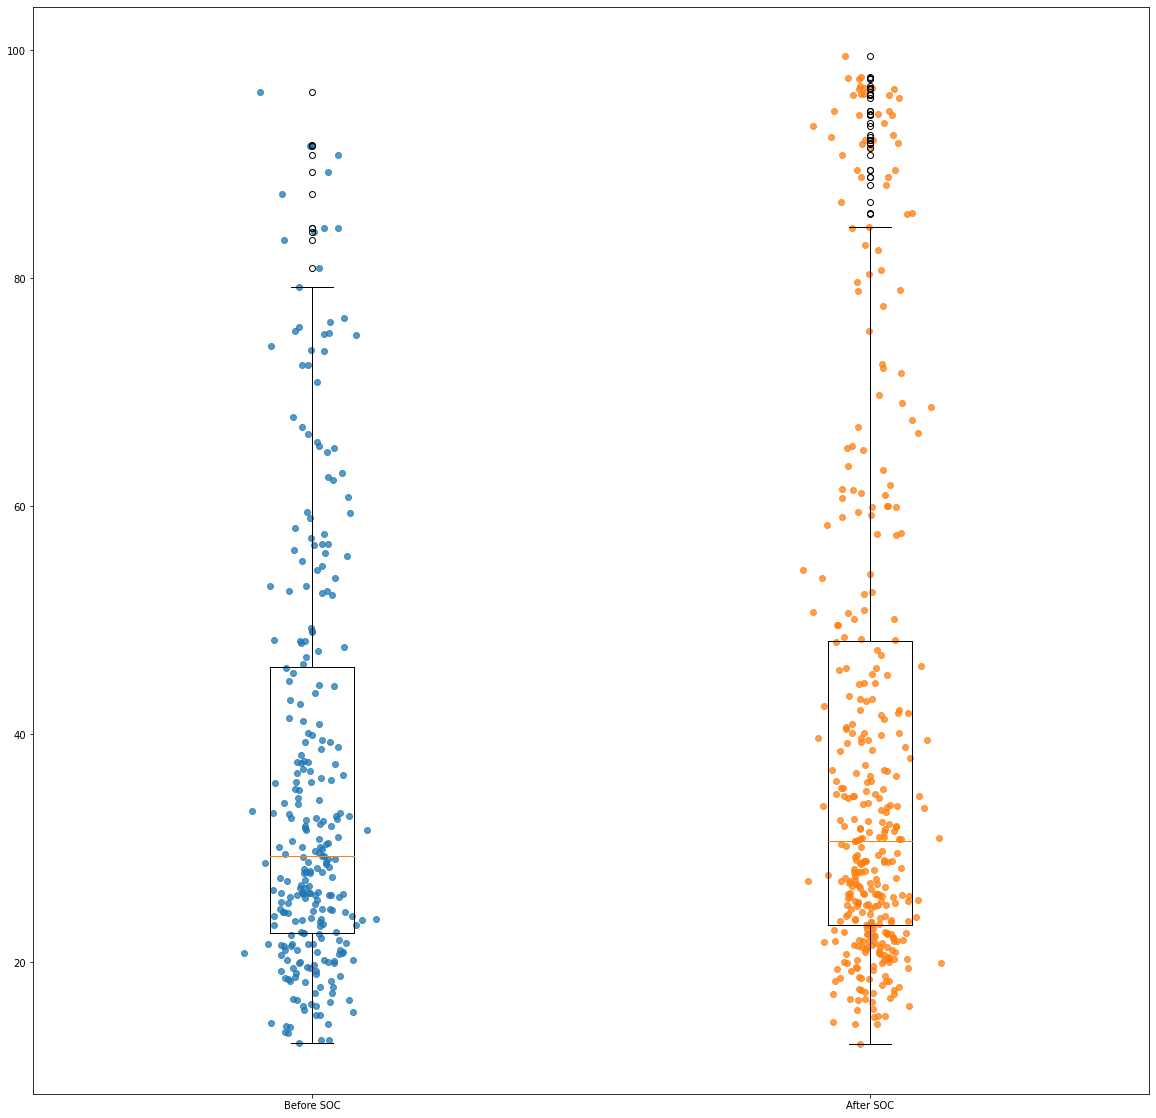

In [21]:
risk = pd.merge(risk, df.loc[:,['record_id', 'sample_date', 'Clade', 'ICU','Number_of_vaccination_doses_before_infection']])

risk['sample_date'] = pd.to_datetime(risk['sample_date'])
beforesocrisk = risk[(risk['sample_date'] < pd.to_datetime('2020-08-01')) ]

aftersocrisk = risk[(risk['sample_date'] >= pd.to_datetime('2020-08-01')) & (risk['sample_date'] <= pd.to_datetime('2021-02-01')) ]


print(mannwhitneyu(beforesocrisk['hosp'].dropna(), aftersocrisk['hosp'].dropna()))

plt.figure(figsize = [20,20])

plt.boxplot(beforesocrisk['hosp'].dropna(), positions = [0], labels = ['Before SOC'])
jitters = np.random.normal(0 , 0.04, beforesocrisk['hosp'].dropna().shape[0])
plt.scatter(jitters, beforesocrisk['hosp'].dropna(), marker = 'o', alpha = 0.75)


plt.boxplot(aftersocrisk['hosp'].dropna(), positions = [1], labels = ['After SOC'])
jitters = np.random.normal(1 , 0.04, aftersocrisk['hosp'].dropna().shape[0])
plt.scatter(jitters, aftersocrisk['hosp'].dropna(), marker = 'o', alpha = 0.75)

# plt.savefig('/Users/tlh4362/Desktop/fig6/fig6e.eps', format = 'eps', bbox_inches = 'tight')

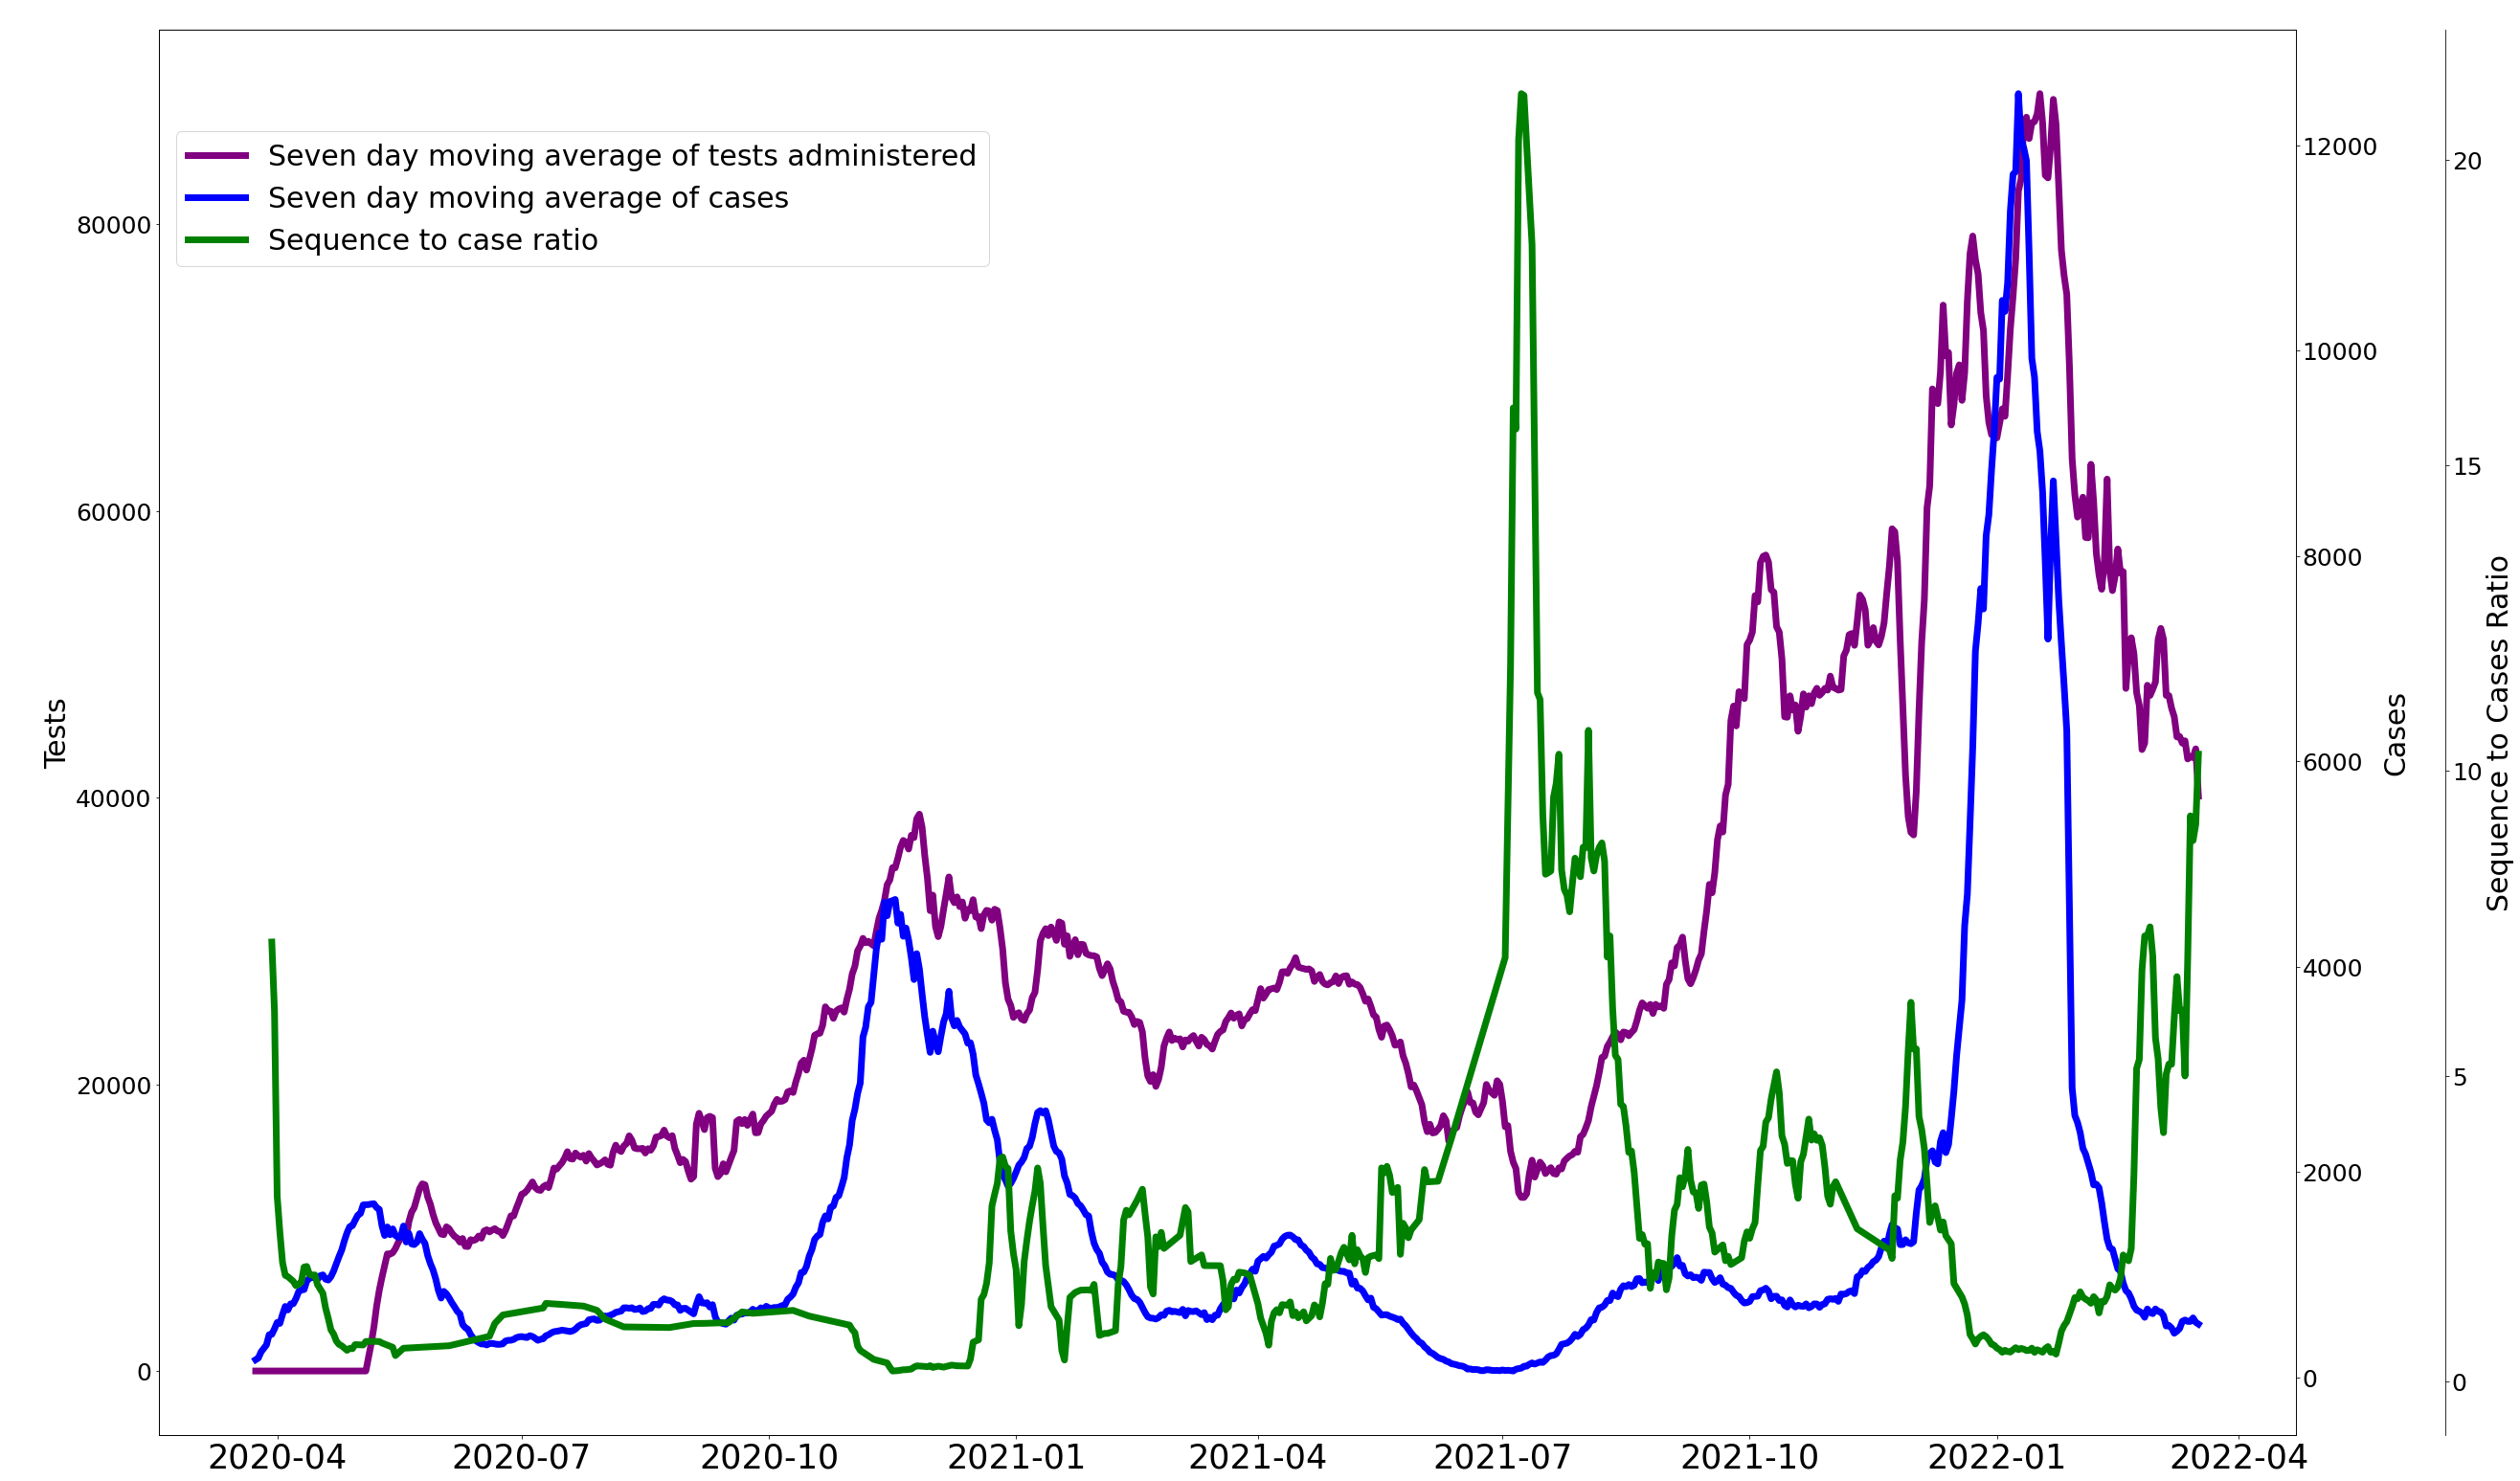

In [22]:
fig6 = fig6.rename({'Unnamed: 0':'sample_date'}, axis = 1)
fig6['sample_date'] = pd.to_datetime(fig6['sample_date'])

fig6['cases'] = fig6.filter(regex = 'case').sum(axis = 1)
fig6['test'] = fig6.filter(regex = 'Test').sum(axis = 1)

fig6['normalized_cases'] =  fig6['cases']/fig6['cases'].max()

daily_seq_counts = {}
normalized_counts = {}
tmp = df[df['Clade'].notnull()]
for date in tmp['sample_date'].unique():
    daily_seq_counts[date] = tmp[tmp['sample_date']==date].shape[0]

for d, c in daily_seq_counts.items():
    normalized_counts[d] = c/max(daily_seq_counts.values())

normalized_counts = pd.DataFrame().from_dict(normalized_counts, orient  = 'index', columns = ['normalized_sequences'])
normalized_counts['sample_date'] = pd.to_datetime(normalized_counts.index)

fig6 = pd.merge(fig6, normalized_counts, how = 'left')

fig6['seq_case_ratio'] = fig6['normalized_sequences']/fig6['normalized_cases']



sc_ratio = []
sampledate = []
for d in fig6[fig6['normalized_sequences'].notnull()]['sample_date'].unique():
    sc_ratio.append(fig6[fig6['sample_date']==d]['seq_case_ratio'].iloc[0])
    sampledate.append(d)

fig, ax = plt.subplots(figsize = [40,27])
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 1.07))

ax.plot(fig6['sample_date'], fig6['test'].rolling(7).mean(), linewidth = 7,color = 'purple', label = 'Seven day moving average of tests administered')
ax2.plot(fig6['sample_date'], fig6['cases'].rolling(7).mean(), linewidth = 7,color = 'blue', label = 'Seven day moving average of cases')
ax3.plot(sampledate, pd.Series(sc_ratio).rolling(7).mean(), linewidth = 7, color = 'g', label = 'Sequence to case ratio')

ax.tick_params(axis = 'y', labelsize = 25)
ax2.tick_params(axis = 'y', labelsize = 25)
ax3.tick_params(axis = 'y', labelsize = 25)

ax.tick_params(axis = 'x', labelsize = 35)
ax.set_ylabel('Tests', fontsize = 30)
ax2.set_ylabel('Cases', fontsize = 30)
ax3.set_ylabel('Sequence to Cases Ratio', fontsize = 30)
fig.legend(loc = [0.07,0.82], fontsize = 30)

# plt.savefig('/Users/tlh4362/Desktop/fig6/fig6a.eps', format = 'eps')
# plt.legend(by_label.values(), by_label.keys())